# Project Name

### Video Used In this Project

In [ ]:
! pip install youtube-comment-downloader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 4.6 MB/s eta 0:00:00


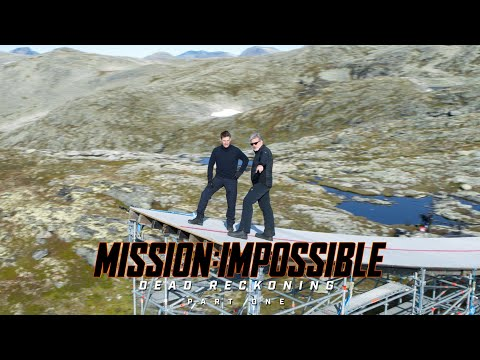

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('-lsFs2615gw', width=800, height=300)

In [ ]:
!pip install transformers
!pip install more-itertools
!pip install pandas
!pip install matplotlib
!pip install nltk
!pip install wordcloud


In [ ]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import pipeline
from itertools import islice
from youtube_comment_downloader import *
import pandas as pd
import tqdm
from matplotlib import pyplot as plt
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Text Classification: Using Transformers Encoder Block
- A transformer is a deep learning model that adopts the mechanism of self-attention, differentially weighting the significance of each part of the input data
- They hold the potential to understand the relationshipbetween sequential elements that are far from each other
- They are way more accurate
- They pay equal attention to all the elements in the sequence

![download.png](attachment:60a7bd61-0889-40fe-9e5c-3038bac0fdaa.png)

In [ ]:

com=[]
downloader = YoutubeCommentDownloader()
comments = downloader.get_comments_from_url('https://www.youtube.com/watch?v=-lsFs2615gw', sort_by=SORT_BY_POPULAR)
for comment in islice(comments, 10000):
    com.append({"Comment" : comment["text"] , "Time" : comment["time"] , "Votes" : comment["votes"]})


In [ ]:
df = pd.DataFrame(com)

In [ ]:
df.head()

,Comment,Time,Votes
0,Watch Mission: Impossible - Dead Reckoning Par...,3 months ago,49
1,The fact that Tom cruise is 60 year old and he...,1 year ago,25K
2,Tom Cruise is the greatest movie star in histo...,1 year ago,7K
3,This 9 minute video on its own feels more inte...,5 months ago,680
4,The fact he’s 60 years old and he’s still doin...,5 months ago (edited),824


## Special Characters Removal
- We will not remove numbers from the text data right away, lets further analyse if they contain any relevant information
- We can find the entity type of the tokens in the sentences using Named Entity Recognition (NER), this will help us identify the type and relevance of numbers in our text data

In [ ]:
def remove_stop_words(example_sent):
    word_tokens = word_tokenize(example_sent)
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    filtered_sentence = []
    str1 = " "

    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)

    return (str1.join(filtered_sentence))

In [ ]:
df["filtered_Comment"] = df["Comment"].apply(remove_stop_words)

In [ ]:
df['Comment_length'] = df['filtered_Comment'].apply(lambda x: len(x.split()))

# Word Visualization: Word Clouds

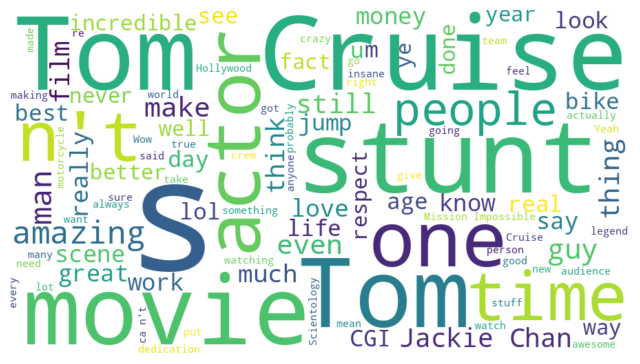

In [ ]:
text = ' '.join(df['filtered_Comment'].tolist())

wordcloud = WordCloud(max_words=100,width=900, height=500, background_color='white', contour_width=3, contour_color='steelblue')
wordcloud.generate(text)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


# Model Building

In [ ]:
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
# This model only exists in PyTorch, so we use the `from_pt` flag to import that model in TensorFlow.
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, from_pt=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)
classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

All the weights of TFBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

## Transformers: Attention is all you need
- For the purpose of classification problem we will only use the encoder block of the original transformers model (encoder-decoder) designed for sequence problems
- Image below is from Jay Alamar's Blog ( For detailed explanation: https://jalammar.github.io/illustrated-transformer/ )

![download2.png](attachment:327ed389-68e3-45b1-97fd-68c144a96d33.png)

![download3.png](attachment:029310dd-a345-41e6-8015-6d8c83ef3ba6.png)

## Multi-Headed Attention
- Multi-head Attention is a module for attention mechanisms which runs through an attention mechanism several times in parallel. The independent attention outputs are then concatenated and linearly transformed into the expected dimension.
- The Self Attention mechanism (illustrated in picture above next to the picture of encoder block) is used several times in parallel in Multi-Head attention
- Multiple attention heads allows for attending to parts of the sequence differently
- During self attention a word's attention score with itself will be the highest, therefore by using mutli-head attention a word can establish its relationship with other words in the sequence by calculating the attention scores with them in parallel

In [ ]:
def bert_star(x):
    return classifier(x[0:100])[0]["label"][:-6]
def bert_score(x):
    return classifier(x[0:100])[0]["score"]

In [ ]:
df["Stars"] = df["filtered_Comment"].apply(bert_star)
df["Score"] = df["filtered_Comment"].apply(bert_score)

In [ ]:
df.to_csv("file.csv")
df = pd.read_csv("file.csv")
df.head()

,Unnamed: 0,Comment,Time,Votes,filtered_Comment,Comment_length,Stars,Score
0,0,Watch Mission: Impossible - Dead Reckoning Par...,3 months ago,49,Watch Mission : Impossible - Dead Reckoning Pa...,16,5.0,0.286571
1,1,The fact that Tom cruise is 60 year old and he...,1 year ago,25K,The fact Tom cruise 60 year old kind stunts si...,11,5.0,0.701848
2,2,Tom Cruise is the greatest movie star in histo...,1 year ago,7K,Tom Cruise greatest movie star history PERIOD ...,24,5.0,0.870064
3,3,This 9 minute video on its own feels more inte...,5 months ago,680,This 9 minute video feels intense Hollywood ac...,11,5.0,0.506084
4,4,The fact he’s 60 years old and he’s still doin...,5 months ago (edited),824,The fact ’ 60 years old ’ still crazy stunts I...,19,5.0,0.805018


# Understanding Audience Sentiments

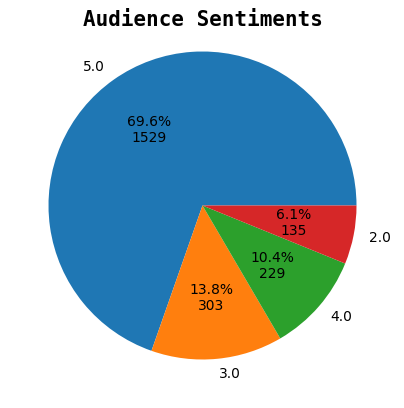

In [ ]:
total = df['Stars'].value_counts().values.sum()
def fmt(x):
    return '{:.1f}%\n{:.0f}'.format(x, total*x/100)
plt.subplots(figsize=(5,5))
plt.pie(df['Stars'].value_counts().values,labels=df['Stars'].value_counts().index,autopct=fmt)
plt.title("Audience Sentiments", fontsize=15, fontweight="bold", fontname="monospace",  y=0.945)
plt.show()

# Understanding Scores
- 5 is given for very good comments
- 4 is given for good comment
- 3 is given for neutral commemt
- 2 is given for negative comment
- 1 is given for very hatefull comment